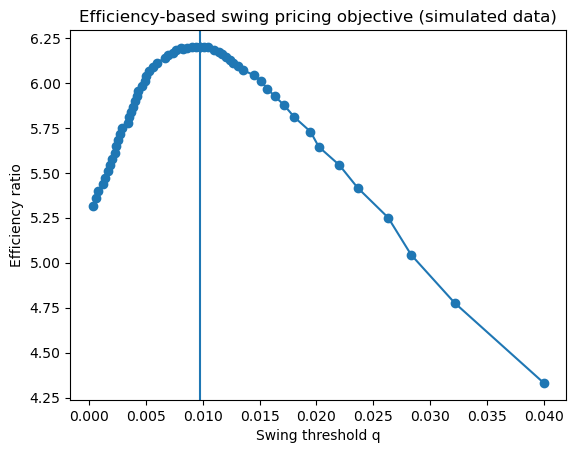

(0.009727841904274745, 6.199972647651186)

In [1]:
# Example using the provided code structure with simulated data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================
# 0. Simulated data
# ============================
np.random.seed(123)
T = 500

# Simulated returns (low-vol fund)
r = pd.Series(np.random.normal(0.0003, 0.004, T))

# Simulated flows (subs-red / AUM), fat-tailed
flow = pd.Series(np.random.standard_t(df=3, size=T) * 0.01)

VL0 = 100.0
swing_factor = 0.002
cost_coeff = 1.0

# ============================================================
# 1. NAV CONSTRUCTION
# ============================================================
def compute_nav(returns, VL0):
    nav = np.zeros(len(returns))
    nav[0] = VL0
    for t in range(1, len(returns)):
        nav[t] = nav[t-1] * (1 + returns.iloc[t])
    return nav

# ============================================================
# 3. SWING MECHANISM
# ============================================================
def compute_swing_adjustment(flow_t, q, swing_factor):
    if flow_t > q:
        return swing_factor
    elif flow_t < -q:
        return -swing_factor
    else:
        return 0.0

def compute_nav_swing(nav, flows, q, swing_factor):
    nav_s = np.zeros_like(nav)
    nav_s[0] = nav[0]
    for t in range(1, len(nav)):
        swing = compute_swing_adjustment(flows.iloc[t], q, swing_factor)
        nav_s[t] = nav[t] * (1 + swing)
    return nav_s

# ============================================================
# 4. SWING-INDUCED DILUTION
# ============================================================
def swing_dilution(flows, q, cost_coeff=1.0):
    dilution = np.zeros(len(flows))
    for t in range(len(flows)):
        if abs(flows.iloc[t]) > q:
            dilution[t] = cost_coeff * abs(flows.iloc[t])
    return dilution

# ============================================================
# 5. NAV DISTORTION
# ============================================================
def nav_distortion(nav, nav_swinged):
    diff = np.log(nav_swinged) - np.log(nav)
    return np.std(diff)

# ============================================================
# 6. EFFICIENCY RATIO
# ============================================================
def efficiency_ratio(q, nav, flows, swing_factor, cost_coeff=1.0, eps=1e-8):
    nav_s = compute_nav_swing(nav, flows, q, swing_factor)
    distortion = nav_distortion(nav, nav_s)
    dilution = np.mean(swing_dilution(flows, q, cost_coeff))
    return dilution / (distortion + eps)

# ============================================================
# 7. OPTIMIZATION
# ============================================================
nav = compute_nav(r, VL0)

abs_flows = np.abs(flow)
q_grid = np.quantile(abs_flows, np.linspace(0.02, 0.98, 60))

scores = np.array([
    efficiency_ratio(q, nav, flow, swing_factor, cost_coeff)
    for q in q_grid
])

q_star = q_grid[np.argmax(scores)]
score_star = scores.max()

# ============================================================
# 8. PLOT OBJECTIVE
# ============================================================
plt.figure()
plt.plot(q_grid, scores, marker="o")
plt.axvline(q_star)
plt.scatter([q_star], [score_star])
plt.xlabel("Swing threshold q")
plt.ylabel("Efficiency ratio")
plt.title("Efficiency-based swing pricing objective (simulated data)")
plt.show()

q_star, score_star
